<h1>Hyperparamter Optimization Using R with Amazon SageMaker</h1>

This sample Notebook demonstrates how to conduct Hyperparamter tuning and how to generate predictions for abalone age using two methods:

- [Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) using a Transformer.
- [Deploying the model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) as an endpoint and making online inferences. 

The goal is to demonstrate how these methods work in R. 

Abalone age is measured by the number of rings in the shell. The notebook will use the public [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) hosted by [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). 

We will use two different libraries to interact with SageMaker:
- [`Reticulate` library](https://rstudio.github.io/reticulate/): that provides an R interface to make API calls [Amazon SageMaker Python SDK](https://sagemaker.readthedocs.io/en/latest/index.html) to make API calls to Amazon SageMaker. The `reticulate` package translates between R and Python objects, and Amazon SageMaker provides a serverless data science environment to train and deploy ML models at scale.
- [`paws` library](https://cran.r-project.org/web/packages/paws/index.html): that provides an interface to make API calls to AWS services, similar to how [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) works. `boto3` is the Amazon Web Services (AWS) SDK for Python. It enables Python developers to create, configure, and manage AWS services, such as EC2 and S3. Boto provides an easy to use, object-oriented API, as well as low-level access to AWS services. `paws` provides the same capabilities in R.

Table of Contents:
- [Reticulating the Amazon SageMaker Python SDK](#Reticulating-the-Amazon-SageMaker-Python-SDK)
- [Creating and Accessing the Data Storage](#Creating-and-accessing-the-data-storage)
- [Downloading and Processing the Dataset](#Downloading-and-processing-the-dataset)
- [Preparing the Dataset for Model Training](#Preparing-the-dataset-for-model-training)
- [Hyperparameter Tuning for the XGBoost Model](#Hyperparameter-Tuning-for-the-XGBoost-Model)
    - [Using the paws Library to Interact with AWS Services and Get the Status of the Tuning Job](#Using-the-paws-Library-to-Interact-with-AWS-Services-and-Get-the-Status-of-the-Tuning-Job)
- [Option 1: Batch Transform](#Option-1:-Batch-Transform)
    - [Create a Model using the Best Training Job](#Create-a-Model-using-the-Best-Training-Job)
    - [Batch Transform using the Tuned Estimator](#Batch-Transform-using-the-Tuned-Estimator)
    - [Download the Data](#Download-the-Data)
- [Option 2: Make Inference using Endpoint](#Option-2:-Make-Inference-using-Endpoint)
    - [Deploying the Tuner](#Deploying-the-Tuner)
    - [Generating Predictions with the Deployed Model](#Generating-Predictions-with-the-Deployed-Model)
    - [Deleting the Endpoint](#Deleting-the-Endpoint)
    
    
**Note:** The first portion of this notebook focused on data ingestion and preparing the data for model training is similar to the data preparation outlined in the ["Using R with Amazon SageMaker"](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/r_kernel/using_r_with_amazon_sagemaker.ipynb) notebook on AWS SageMaker Examples Github repository with some modifications.
Also the last portion of this notebook focused on making inference using an endpoint is inspired by the method outlined in the notebook referenced [here](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/r_examples/r_end_2_end/r_sagemaker_abalone.ipynb).

<h3>Reticulating the Amazon SageMaker Python SDK</h3>

First, load the `reticulate` library and import the `sagemaker` Python module. Once the module is loaded, use the `$` notation in R instead of the `.` notation in Python to use available classes. 

In [1]:
# Turn warnings off globally
options(warn=-1)

In [2]:
# Install reticulate library and import sagemaker
library(reticulate)
sagemaker <- import('sagemaker')

<h3>Creating and Accessing the Data Storage</h3>

The `Session` class provides operations for working with the following [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) resources with Amazon SageMaker:

* [S3](https://boto3.readthedocs.io/en/latest/reference/services/s3.html)
* [SageMaker](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker.html)
* [SageMakerRuntime](https://boto3.readthedocs.io/en/latest/reference/services/sagemaker-runtime.html)

Let's create an [Amazon Simple Storage Service](https://aws.amazon.com/s3/) bucket for your data. 

In [3]:
session <- sagemaker$Session()
bucket <- session$default_bucket()

**Note** - The `default_bucket` function creates a unique Amazon S3 bucket with the following name: 

`sagemaker-<aws-region-name>-<aws account number>`

Specify the IAM role's [ARN](https://docs.aws.amazon.com/general/latest/gr/aws-arns-and-namespaces.html) to allow Amazon SageMaker to access the Amazon S3 bucket. You can use the same IAM role used to create this Notebook:

In [4]:
role_arn <- sagemaker$get_execution_role()

<h3>Downloading and Processing the Dataset</h3>

The model uses the [abalone dataset](https://archive.ics.uci.edu/ml/datasets/abalone) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). First, download the data and start the [exploratory data analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis). Use tidyverse packages to read, plot, and transform the data into ML format for Amazon SageMaker:

In [5]:
library(readr)
data_file <- 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
abalone <- read_csv(file = data_file, col_names = FALSE)
names(abalone) <- c('sex', 'length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'rings')
head(abalone)


── Column specification ────────────────────────────────────────────────────────
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)




sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


The output above shows that `sex` is a factor data type but is currently a character data type (F is Female, M is male, and I is infant). Change `sex` to a factor and view the statistical summary of the dataset:

In [6]:
abalone$sex <- as.factor(abalone$sex)
summary(abalone)

 sex          length         diameter          height        whole_weight   
 F:1307   Min.   :0.075   Min.   :0.0550   Min.   :0.0000   Min.   :0.0020  
 I:1342   1st Qu.:0.450   1st Qu.:0.3500   1st Qu.:0.1150   1st Qu.:0.4415  
 M:1528   Median :0.545   Median :0.4250   Median :0.1400   Median :0.7995  
          Mean   :0.524   Mean   :0.4079   Mean   :0.1395   Mean   :0.8287  
          3rd Qu.:0.615   3rd Qu.:0.4800   3rd Qu.:0.1650   3rd Qu.:1.1530  
          Max.   :0.815   Max.   :0.6500   Max.   :1.1300   Max.   :2.8255  
 shucked_weight   viscera_weight    shell_weight        rings       
 Min.   :0.0010   Min.   :0.0005   Min.   :0.0015   Min.   : 1.000  
 1st Qu.:0.1860   1st Qu.:0.0935   1st Qu.:0.1300   1st Qu.: 8.000  
 Median :0.3360   Median :0.1710   Median :0.2340   Median : 9.000  
 Mean   :0.3594   Mean   :0.1806   Mean   :0.2388   Mean   : 9.934  
 3rd Qu.:0.5020   3rd Qu.:0.2530   3rd Qu.:0.3290   3rd Qu.:11.000  
 Max.   :1.4880   Max.   :0.7600   Max.   :1.00

The summary above shows that the minimum value for `height` is 0.

Visually explore which abalones have height equal to 0 by plotting the relationship between `rings` and `height` for each value of `sex`:

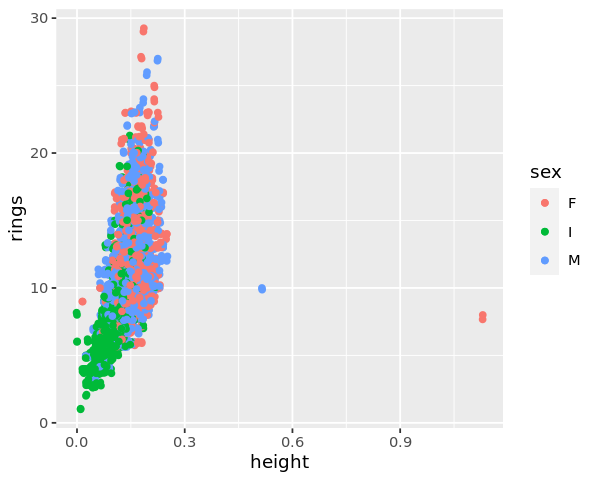

In [7]:
library(ggplot2)
options(repr.plot.width = 5, repr.plot.height = 4) 
ggplot(abalone, aes(x = height, y = rings, color = sex)) + geom_point() + geom_jitter()

The plot shows multiple outliers: two infant abalones with a height of 0 and a few female and male abalones with greater heights than the rest. Let's filter out the two infant abalones with a height of 0.

In [8]:
library(dplyr)
abalone <- abalone %>%
  filter(height != 0)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




<h3>Preparing the Dataset for Model Training</h3>

The model needs three datasets: one for training, testing, and validation. First, convert `sex` into a [dummy variable](https://en.wikipedia.org/wiki/Dummy_variable_(statistics)) and move the target, `rings`, to the first column. Amazon SageMaker algorithm require the target to be in the first column of the dataset.

In [9]:
abalone <- abalone %>%
  mutate(female = as.integer(ifelse(sex == 'F', 1, 0)),
         male = as.integer(ifelse(sex == 'M', 1, 0)),
         infant = as.integer(ifelse(sex == 'I', 1, 0))) %>%
  select(-sex)
abalone <- abalone %>%
  select(rings:infant, length:shell_weight)
head(abalone)

rings,female,male,infant,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15,0,1,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
7,0,1,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
9,1,0,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
10,0,1,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
7,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055
8,0,0,1,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120


Next, sample 70% of the data for training the ML algorithm. Split the remaining 30% into two halves, one for testing and one for validation:

In [10]:
abalone_train <- abalone %>%
  sample_frac(size = 0.7)
abalone <- anti_join(abalone, abalone_train)
abalone_test <- abalone %>%
  sample_frac(size = 0.5)
abalone_valid <- anti_join(abalone, abalone_test)

Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")

Joining, by = c("rings", "female", "male", "infant", "length", "diameter", "height", "whole_weight", "shucked_weight", "viscera_weight", "shell_weight")



Later in the notebook, we are going to use Batch Transform and Endpoint to make inference in two different ways and we will compare the results. The maximum number of rows that we can send to an endpoint for inference in one batch is 500 rows. We are going to reduce the number of rows for the test dataset to 500 and use this for batch and online inference for comparison. 

In [11]:
num_predict_rows <- 500
abalone_test <- abalone_test[1:num_predict_rows, ]

Upload the training and validation data to Amazon S3 so that you can train the model. First, write the training and validation datasets to the local filesystem in .csv format:

In [12]:
write_csv(abalone_train, 'abalone_train.csv', col_names = FALSE)
write_csv(abalone_valid, 'abalone_valid.csv', col_names = FALSE)

# Remove target from test
write_csv(abalone_test[-1], 'abalone_test.csv', col_names = FALSE)

Second, upload the two datasets to the Amazon S3 bucket into the `data` key:

In [13]:
s3_train <- session$upload_data(path = 'abalone_train.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')
s3_valid <- session$upload_data(path = 'abalone_valid.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')

s3_test <- session$upload_data(path = 'abalone_test.csv', 
                                bucket = bucket, 
                                key_prefix = 'data')

Finally, define the Amazon S3 input types for the Amazon SageMaker algorithm:

In [14]:
s3_train_input <- sagemaker$session$s3_input(s3_data = s3_train,
                                     content_type = 'csv')
s3_valid_input <- sagemaker$session$s3_input(s3_data = s3_valid,
                                     content_type = 'csv')

<h3>Hyperparameter Tuning for the XGBoost Model</h3>

Amazon SageMaker algorithms are available via a [Docker](https://www.docker.com/) container. To train an [XGBoost](https://en.wikipedia.org/wiki/Xgboost) model, specify the training containers in [Amazon Elastic Container Registry](https://aws.amazon.com/ecr/) (Amazon ECR) for the AWS Region.

In [15]:
registry <- sagemaker$amazon$amazon_estimator$get_image_uri(
    region_name=session$boto_region_name,
    repo_name='xgboost',
    repo_version='latest')
                                    
container <- paste(registry)
container


cat('XGBoost Container Image URL: ', container)

[1] "811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest"

XGBoost Container Image URL:  811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest

Define an Amazon SageMaker [Estimator](http://sagemaker.readthedocs.io/en/latest/estimators.html), which can train any supplied algorithm that has been containerized with Docker. When creating the Estimator, use the following arguments:
* **image_name** - The container image to use for training
* **role** - The Amazon SageMaker service role
* **train_instance_count** - The number of Amazon EC2 instances to use for training
* **train_instance_type** - The type of Amazon EC2 instance to use for training
* **train_volume_size** - The size in GB of the [Amazon Elastic Block Store](https://aws.amazon.com/ebs/) (Amazon EBS) volume to use for storing input data during training
* **train_max_run** - The timeout in seconds for training
* **input_mode** - The input mode that the algorithm supports
* **output_path** - The Amazon S3 location for saving the training results (model artifacts and output files)
* **output_kms_key** - The [AWS Key Management Service](https://aws.amazon.com/kms/) (AWS KMS) key for encrypting the training output
* **base_job_name** - The prefix for the name of the training job
* **sagemaker_session** - The Session object that manages interactions with Amazon SageMaker API

In [16]:
s3_output <- paste0('s3://', bucket, '/output')
estimator <- sagemaker$estimator$Estimator(image_uri = container,
                                           role = role_arn,
                                           train_instance_count = 1L,
                                           train_instance_type = 'ml.m5.4xlarge',
                                           train_volume_size = 30L,
                                           train_max_run = 3600L,
                                           input_mode = 'File',
                                           output_path = s3_output,
                                           output_kms_key = NULL,
                                           base_job_name = NULL,
                                           sagemaker_session = NULL)

**Note** - The equivalent to `None` in Python is `NULL` in R.

Next, we Specify the [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for the estimator, and also define the range of hyperparameters that we want to use for [SageMaker Hyperparamter Tuning](https://sagemaker.readthedocs.io/en/stable/tuner.html). You can find the list of [Tunable Hyperparamters for XGBoost algorithm here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html). 

In addition, you need to specify the tuning evaluation metric. XGboost allows one of these nine objectives to be used (for the description of these objectives visit ["Tune an XGBoost Model"](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost-tuning.html) page) :

- validation:accuracy
- validation:auc
- validation:error
- validation:f1
- validation:logloss
- validation:mae
- validation:map
- validation:merror
- validation:mlogloss
- validation:mse
- validation:ndcg
- validation:rmse	

In this case, since this is a regression problem, we select `validation:rmse` as the tuning objective.

For tuning the hyperparamters you need to also specify the type and range of hyperparamters to be tuned. You can specify either a `ContinuousParameter` or an `IntegerParameter`, as outlined in the documentation. In addition, the algorithm documentation provides suggestions for the hyperparamter range.


Once the Estimator and its hyperparamters and tunable hyperparamter ranges are specified, you can create a `HyperparameterTuner` (tuner). You can train (or fit) that tuner which will conduct the tuning and will select the most optimzied model. You can then generate predictions using this model with Batch Transform, or by deploying the model as an endpoint and using it for online inference.

In [17]:
# Set Hyperparameters
estimator$set_hyperparameters(eval_metric='rmse',
                              objective='reg:linear',
                              num_round=100L,
                              rate_drop=0.3,
                              tweedie_variance_power=1.4)

In [18]:
# Set Hyperparameter Ranges
hyperparameter_ranges = list('eta' = sagemaker$parameter$ContinuousParameter(0,1),
                        'min_child_weight'= sagemaker$parameter$ContinuousParameter(0,10),
                        'alpha'= sagemaker$parameter$ContinuousParameter(0,2),
                        'max_depth'= sagemaker$parameter$IntegerParameter(0L,10L)
                            )

In [19]:
# Set the tuning objective to RMSE
objective_metric_name = 'validation:rmse'

The `HyperparameterTuner` accepts multiple paramters. A short list of these parameters are described below. For the complete list and more details you can visit [`HyperparameterTuner` Documentation](https://sagemaker.readthedocs.io/en/stable/tuner.html#hyperparametertuner) :

- **estimator** (sagemaker.estimator.EstimatorBase) – An estimator object that has been initialized with the desired configuration. There does not need to be a training job associated with this instance.
- **objective_metric_name** (str) – Name of the metric for evaluating training jobs.
- **hyperparameter_ranges** (dict[str, sagemaker.parameter.ParameterRange]) – Dictionary of parameter ranges. These parameter ranges can be one of three types: Continuous, Integer, or Categorical. 
- **objective_type** (str) – The type of the objective metric for evaluating training jobs. This value can be either ‘Minimize’ or ‘Maximize’ (default: ‘Maximize’).
- **max_jobs** (int) – Maximum total number of training jobs to start for the hyperparameter tuning job (default: 1).
- **max_parallel_jobs** (int) – Maximum number of parallel training jobs to start (default: 1).

In [20]:
# Create a hyperparamter tuner
tuner <- sagemaker$tuner$HyperparameterTuner(estimator,
                                             objective_metric_name,
                                             hyperparameter_ranges,
                                             objective_type='Minimize',
                                             max_jobs=10L,
                                             max_parallel_jobs=4L)



In [21]:
# Create a tuning job name
job_name <- paste('sagemaker-tune-xgboost', format(Sys.time(), '%H-%M-%S'), sep = '-')

# Define the data channels for train and validation datasets
input_data <- list('train' = s3_train_input,
                   'validation' = s3_valid_input)

# train the tuner
tuner$fit(inputs = input_data, job_name = job_name, include_cls_metadata=FALSE)

#### Using the `paws` Library to Interact with AWS Services and Get the Status of the Tuning Job

[`paws` package](https://cran.r-project.org/web/packages/paws/index.html) provides the programmer with an Amazon Web Services (AWS) Software Development Kit (SDK) to interact with AWS resources including storage, database, and compute services. It is equivalent of Python's `boto3` but for R. 

Since running a tuning job may take a while, we are going to use `paws` SageMaker to get the status of the tuning job using `sagemaker$describe_hyper_parameter_tuning_job`. Using `paws` in conjunction with `reticulate` you can interact with AWS services as outlined below. [More detailed documenation of `paws` package can be found here](https://cran.r-project.org/web/packages/paws/paws.pdf).

In [ ]:
# Install paws package
install.packages('paws')
library(paws)

also installing the dependencies ‘ini’, ‘paws.common’, ‘paws.compute’, ‘paws.storage’, ‘paws.database’, ‘paws.networking’, ‘paws.management’, ‘paws.machine.learning’, ‘paws.analytics’, ‘paws.security.identity’, ‘paws.application.integration’, ‘paws.cost.management’, ‘paws.customer.engagement’




In [ ]:
# Create a paws SageMaker session
sm <- paws::sagemaker()

In [ ]:
# Get the status of the tuning job
status <- sm$describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner$latest_tuning_job$job_name)

cat('Hyperparameter Tuning Job Name: ', job_name,'\n')
cat('Hyperparameter Tuning Job Status: ', status$HyperParameterTuningJobStatus,'\n')
cat('Succeeded Models:', status$ObjectiveStatusCounters$Succeeded,'\n')
cat('InProgress Modles:', status$ObjectiveStatusCounters$Pending,'\n')
cat('Failed Modles:', status$ObjectiveStatusCounters$Failed,'\n')


In [ ]:
# Print best training hyperparamters
status$BestTrainingJob$TunedHyperParameters

In [ ]:
# Print Evaluation Metric
status$BestTrainingJob$FinalHyperParameterTuningJobObjectiveMetric

In [ ]:
# Name of the best training job model
status$BestTrainingJob$TrainingJobName

<hr>

## Option 1: Batch Transform

### Create a Model using the Best Training Job
This section demonstrates how to create a model using the best training job results from the HPO task, and using the model artifacts saved on S3.

First, we need to create a model container, which needs the following parameters:
- **Image:** URL of the algorithm container 
- **ModelDataUrl:** Location of the model tar ball (model.tar.gz) on S3 that is saved by the Hyperparamter training job

We can extract the **ModelDataUrl** by describing the best training job using `paws` library and `describe_training_job()` method. [More details can be found here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.describe_training_job).
 
Then we will create a model using this model container. We will use `paws` library and `create_model` method. [Documentation of this method can be found here](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model). 

In [ ]:
# Describe best training model from hypertuning to get the location of the model artifact on S3
model_artifact <- sm$describe_training_job(
    TrainingJobName = status$BestTrainingJob$TrainingJobName
)$ModelArtifacts$S3ModelArtifacts

model_artifact

In [ ]:
# Create a model container
model_container <- list(
    "Image"= container,
    "ModelDataUrl" = model_artifact
    )

In [ ]:
# Create a model

model_name <- paste('sagemaker-model-xgboost', format(Sys.time(), '%H-%M-%S'), sep = '-')

best_model <- sm$create_model(
    ModelName = model_name,
    PrimaryContainer = model_container,
    ExecutionRoleArn = role_arn
)

### Batch Transform using the Tuned Estimator

For more details on SageMaker Batch Transform, you can visit this example notebook on [Amazon SageMaker Batch Transform](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_batch_transform/introduction_to_batch_transform/batch_transform_pca_dbscan_movie_clusters.ipynb).

In many situations, using a deployed model for making inference is not the best option, especially when the goal is not to make online real-time inference but to generate predictions from a trained model on a large dataset. In these situations, using Batch Transform may be more efficient and appropriate.

This section of the notebook explain how to set up the Batch Transform Job, and generate predictions.

To do this, first we need to define the batch input data path on S3, and also where to save the generated predictions on S3.

In [ ]:
# Define S3 path for Test data and output path

s3_test_url <- paste('s3:/',bucket,'data','abalone_test.csv', sep = '/')
output_path <- paste('s3:/',bucket,'output/batch_transform_output',job_name, sep = '/')

Then we create a `Transformer`. [Transformers](https://sagemaker.readthedocs.io/en/stable/transformer.html#transformer) take multiple paramters, including the following. For more details and the complete list visit the [documentation page](https://sagemaker.readthedocs.io/en/stable/transformer.html#transformer).

- **model_name** (str) – Name of the SageMaker model being used for the transform job.
- **instance_count** (int) – Number of EC2 instances to use.
- **instance_type** (str) – Type of EC2 instance to use, for example, ‘ml.c4.xlarge’.

- **output_path** (str) – S3 location for saving the transform result. If not specified, results are stored to a default bucket.

- **base_transform_job_name** (str) – Prefix for the transform job when the transform() method launches. If not specified, a default prefix will be generated based on the training image name that was used to train the model associated with the transform job.

- **sagemaker_session** (sagemaker.session.Session) – Session object which manages interactions with Amazon SageMaker APIs and any other AWS services needed. If not specified, the estimator creates one using the default AWS configuration chain.

Once we create a `Transformer` we can transform the batch input.

In [ ]:
# Instantiate a SageMaker transformer
transformer <- sagemaker$transformer$Transformer(
    model_name = model_name,
    instance_count=1L,
    instance_type='ml.m5.4xlarge',
    output_path=output_path,
    base_transform_job_name='R-Transformer',
    sagemaker_session=session)

In [ ]:
# Tranform the test data and wait until the task completes
transformer$transform(s3_test_url)
transformer$wait()

In [ ]:
# Get the status of Batch Transform
sm$describe_transform_job(TransformJobName = transformer$latest_transform_job$job_name)$TransformJobStatus


### Download the Data

In [ ]:
sagemaker$s3$S3Downloader$download(paste(output_path,"abalone_test.csv.out",sep = '/'),
                          "batch_output")

In [ ]:
# Read the batch csv from sagemaker local files
library(readr)
predictions <- read_csv(file = 'batch_output/abalone_test.csv.out', col_names = 'predicted_rings')
head(predictions)

Column-bind the predicted rings to the test data:

In [ ]:
# Concatenate predictions and test for comparison
abalone_predictions <- cbind(predicted_rings = predictions, 
                      abalone_test)
# Convert predictions to Integer
abalone_predictions$predicted_rings = as.integer(abalone_predictions$predicted_rings);
head(abalone_predictions)

In [ ]:
# Define a function to calculate RMSE
rmse <- function(m, o){
  sqrt(mean((m - o)^2))
}

In [ ]:
# Calucalte RMSE
abalone_rmse <- rmse(abalone_predictions$rings, abalone_predictions$predicted_rings)
cat('RMSE for Batch Transform: ', round(abalone_rmse, digits = 2))

<hr>

## Option 2: Make Inference using Endpoint
<h3>Deploying the Tuner</h3>

This section walks you through the deployment process of the tuned/trained model. We will then use the deployed model (as an endpoint) to make predictions using the test data. Deploying the model as as endpoint is suitable for cases where you need to make online inference. For making predictions using batch data, the preferred method is using Batch Transform, which was demonstrated in the previous section.

Amazon SageMaker lets you [deploy your model](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html) by providing an endpoint that consumers can invoke by a secure and simple API call using an HTTPS request. Let's deploy our trained model to a `ml.t2.medium` instance. This will take a couple of minutes.

In [ ]:
model_endpoint <- tuner$deploy(initial_instance_count = 1L,
                                   instance_type = 'ml.t2.medium')

<h3>Generating Predictions with the Deployed Model</h3>

Use the test data to generate predictions. Pass comma-separated text to be serialized into JSON format by specifying `text/csv` and `csv_serializer` for the endpoint:

In [ ]:
model_endpoint$content_type <- 'text/csv'
model_endpoint$serializer <- sagemaker$predictor$csv_serializer

Remove the target column and convert the dataframe to a matrix with no column names:

In [ ]:
test_sample <- as.matrix(abalone_test[-1])
dimnames(test_sample)[[2]] <- NULL

**Note** - 500 observations was chosen because it doesn't exceed the endpoint limitation.

Generate predictions from the endpoint and convert the returned comma-separated string:

In [ ]:
library(stringr)
predictions_ep <- model_endpoint$predict(test_sample)
predictions_ep <- str_split(predictions_ep, pattern = ',', simplify = TRUE)
predictions_ep <- as.integer(unlist(predictions_ep))

Column-bind the predicted rings to the test data:

In [ ]:
# Convert predictions to Integer
abalone_predictions_ep <- cbind(predicted_rings = predictions_ep, 
                      abalone_test)
# abalone_predictions = as.integer(abalone_predictions)
head(abalone_predictions_ep)

In [ ]:
# Calucalte RMSE
abalone_rmse_ep <- rmse(abalone_predictions_ep$rings, abalone_predictions_ep$predicted_rings)
cat('RMSE for Endpoint 500-Row Prediction: ', round(abalone_rmse_ep, digits = 2))

<h3>Deleting the Endpoint</h3>

When you're done with the model, delete the endpoint to avoid incurring deployment costs:

In [ ]:
session$delete_endpoint(model_endpoint$endpoint)